# LSTM - bert128

- **Training set**: LO_SARD102
- **Test/Validation set:** JTT
- **Features**: bert sequence (64)
- **Class imbalance processing**: Class weights

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter

X_train = numpy.load('/mnt/md0/user/scheuererra68323/LOSARD102_bert64_X.npy')
Y_train = pd.read_hdf('/mnt/md0/user/scheuererra68323/LOSARD102_bert64_y.h5').is_vulnerable.values

X_test = numpy.load('/mnt/md0/user/scheuererra68323/JTT_bert64_X.npy')
Y_test = pd.read_hdf('/mnt/md0/user/scheuererra68323/JTT_bert64_y.h5').is_vulnerable.values

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=10
)
print("Training dataset label counts:", Counter(Y_train))
classWeights = {
    0: ( 1 / Counter(Y_train)[0] ) * Y_train.shape[0] / 2.0 ,
    1: ( 1 / Counter(Y_train)[1] ) * Y_train.shape[0] / 2.0
}
print(f"\nclassWeights: {classWeights}\n")

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

Training dataset label counts: Counter({0: 15656, 1: 308})

classWeights: {0: 0.5098364844149208, 1: 25.915584415584416}

(15964, 64, 768)
(15964,)
(3991, 64, 768)
(3991,)
(5607, 64, 768)
(5607,)


In [2]:
def run_classifier():
    model = keras.Sequential()
    model.add( layers.LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), 
                          return_sequences=True) )
    model.add( layers.Dropout(0.1) )
    model.add( layers.TimeDistributed(layers.Dense(16)) )
    model.add( layers.Flatten())
    model.add( layers.Dense(1, activation='sigmoid') )

    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy']
                 )
    
    classWeights = {
        0: ( 1 / Counter(Y_train)[0] ) * Y_train.shape[0] / 2.0 ,
        1: ( 1 / Counter(Y_train)[1] ) * Y_train.shape[0] / 2.0
    }
    print(f"\nclassWeights: {classWeights}\n")

    history = model.fit(X_train, Y_train,
                        batch_size=512,
                        epochs=8,
                        verbose=True,
                        validation_data=(X_val, Y_val),
                        class_weight=classWeights
                        )
    
    return model, history


model, history = run_classifier()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64, 256)           1049600   
_________________________________________________________________
dropout (Dropout)            (None, 64, 256)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 64, 16)            4112      
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 1,054,737
Trainable params: 1,054,737
Non-trainable params: 0
_________________________________________________________________

classWeights: {0: 0.5098364844149208, 1: 25.915584415584416}

Epoch 1/8
32/32 [==============================] 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5578
           1       0.00      0.00      0.00        29

    accuracy                           0.99      5607
   macro avg       0.50      0.50      0.50      5607
weighted avg       0.99      0.99      0.99      5607

Confusion matrix:
[[5578    0]
 [  29    0]]

Confusion matrix (Percentages):
[[99.483  0.   ]
 [ 0.517  0.   ]]

Metrics:
Sensitivity (TPR): 0.000000
Specifity (TNR):   1.000000

FPR: 0.000000
FNR: 1.000000

Balanced accuracy: 0.500000

Test loss:	0.049004
Test accuracy:	0.994828


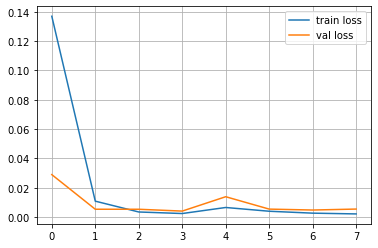

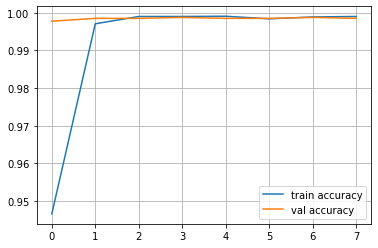

In [3]:
def evaluate_classifier(_model, _history):
    Y_pred = numpy.round(_model.predict(X_test))

    print(classification_report(Y_test, Y_pred))
    print_metrics(confusion_matrix(Y_test, Y_pred), Y_test)
    print()
    score = _model.evaluate(X_test, Y_test, verbose=False)
    print('Test loss:\t{:.6f}'.format(score[0]))
    print('Test accuracy:\t{:.6f}'.format(score[1]))

    plot_loss(_history)
    plot_accuracy(_history)


evaluate_classifier(model, history)

In [4]:
model.save('testJTT_LSTM_bert64_weighted.h5')